In [170]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import recharge_funcs as rf
import baseflow
from pathlib import Path
import sys
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#Scalable, Normalize
import matplotlib as mpl
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
#segoe UI
plt.rcParams['font.family'] = 'Segoe UI'

#### Model Evaluation
Seasonal comparison of discharge and baseflow

In [168]:
models = ["GFDL-ESM4", "IPSL-CM6A-LR", "MPI-ESM1-2-HR", "MRI-ESM2-0", "UKESM1-0-LL"]

#station coordinates
station_locations = pd.read_csv("mHM_eval_stations.csv")
#Boundaries data
be_shp = gpd.read_file(r"W:/VUB/_main_research/mHM/mhm_belgium/be_shp/be.shp")

#rivers
rivers_shp = gpd.read_file(r"W:/VUB/_main_research/data/shapefiles/HydroRIVERS_v10_eu_shp/HydroRIVERS_v10_eu_shp/hydroRivers_BE.shp")

#Open picked flow data for evaluation stations
with open("eval_stations_Q.pickle", "rb") as f:
    eval_Obs = pickle.load(f)

#read validation stations (NSE>0) #from the flow_validation notebook
val_gdf = pd.read_csv('validation_stations_NSE_above_0.csv')

#Canals to be removed
canals = ['HACCOURT', 'Merendree_Afleidingskl Leie', 'Damme_Leopoldkl']

#Extract only stations in val_gdf
eval_Obs = {k: v for k, v in eval_Obs.items() if k in val_gdf['name'].values}

# Remove canal stations
eval_Obs = {k: v for k, v in eval_Obs.items() if k not in canals}

seasons = ['DJF', 'MAM', 'JJA', 'SON']

season_map = {12:"DJF",1:"DJF",2:"DJF",
            3:"MAM",4:"MAM",5:"MAM",
            6:"JJA",7:"JJA",8:"JJA",
            9:"SON",10:"SON",11:"SON"}

#### Seasonal comparison of per-station Q

In [13]:
base_sim_dir = "./isimip_Q"
sim_subfolder = "Qrouted"

#Extract and seasonalize total discharge
model_seasons_df = rf.seasonal_Q_comparison(base_sim_dir, sim_subfolder, models, eval_Obs, season_map)


In [ ]:
#extract multistation baseflow
baseflow_models, all_models_BFI = rf.extract_multistation_baseflow(base_sim_dir, sim_subfolder, models, eval_Obs)

In [15]:
#seasonalize baseflow
seasonal_bf = rf.seasonal_baseflow_analysis(baseflow_models, models, season_map)

#### Comparison scatterplots

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score  # add this import at the top

def plot_multimodel_spread(flow_df: dict, seasons: dict,
                           obs_name: str, sim_name: str,
                           xlabel: str,
                           ylabel: str):
    """
    Plot the spread of simulated vs observed baseflow for multiple models with 95PPU
    and compute the P-factor and R².
    """
    plt.figure(figsize=(8,6), dpi=120)

    all_obs = []
    all_mean_sim = []
    for season in seasons:
        for station in flow_df['name'].unique():
            q_sim_season = flow_df.loc[
                (flow_df['season'] == season) &
                (flow_df['name'] == station), sim_name]
            
            eval_Obs_season = flow_df.loc[
                (flow_df['season'] == season) &
                (flow_df['name'] == station), obs_name]

            mean_sim = q_sim_season.mean()
            min_sim = q_sim_season.min()
            max_sim = q_sim_season.max()
            x_obs = eval_Obs_season.mean()

            all_obs.append(x_obs)
            all_mean_sim.append(mean_sim)

            plt.errorbar(
                x_obs, mean_sim,
                yerr=[[mean_sim - min_sim], [max_sim - mean_sim]],
                fmt='o', color='dodgerblue', markersize=5,
                alpha=0.6, capsize=2, ecolor='gray', elinewidth=0.7, capthick=0.6
            )

    # arrays
    all_obs = np.array(all_obs)
    all_mean_sim = np.array(all_mean_sim)

    # ---- Compute R² ----
    r2 = r2_score(all_obs, all_mean_sim)
    print(f"Coefficient of determination (R²): {r2:.2f}")

    # ---- Compute r ----
    r = np.corrcoef(all_obs, all_mean_sim)[0, 1]
    print(f"Correlation coefficient (r): {r:.2f}")

    # residuals and 95PPU
    residuals = all_mean_sim - all_obs
    lower = np.percentile(residuals, 2.5)
    upper = np.percentile(residuals, 97.5)

    # 1:1 line
    lims = [0, 60]
    plt.plot(lims, lims, 'r-', lw=1)

    # 95PPU band
    x_line = np.linspace(lims[0], lims[1], 200)
    plt.fill_between(x_line, x_line + lower, x_line + upper,
                     color='gray', alpha=0.2, label='95PPU')

    # ---- Compute P-factor ----
    inside = ((all_mean_sim >= all_obs + lower) & (all_mean_sim <= all_obs + upper))
    p_factor = inside.mean() * 100
    print(f"P-factor (percentage of points within 95PPU): {p_factor:.1f}%")

    # annotate R² and P-factor on plot
    plt.text(0.05, 0.92,
             f"$R^2$ = {r2:.2f}\nP-factor = {p_factor:.1f}%",
             transform=plt.gca().transAxes,
             fontsize=11, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # axes, labels
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.grid(alpha=0.4)
    plt.show()


Coefficient of determination (R²): 0.88
Correlation coefficient (r): 0.96
P-factor (percentage of points within 95PPU): 94.9%


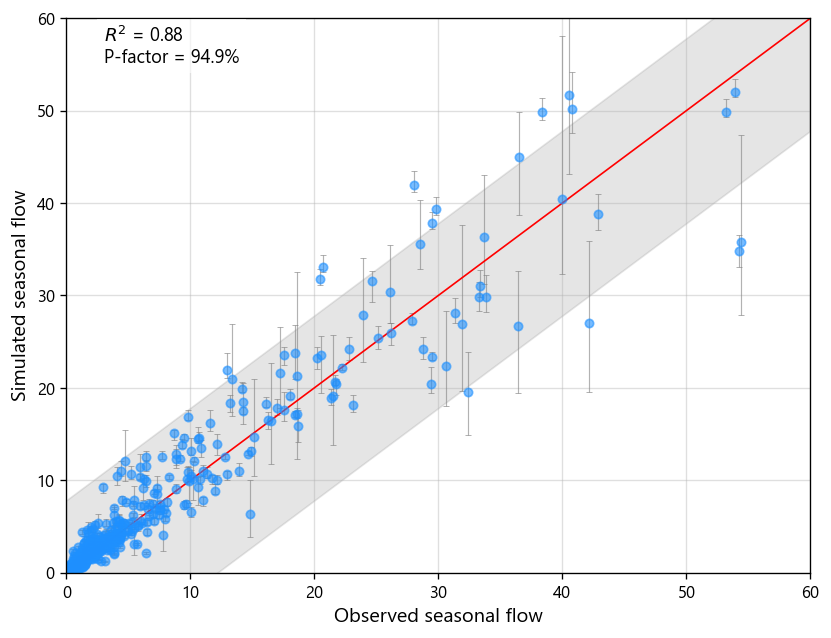

In [17]:
plot_multimodel_spread(model_seasons_df, seasons,
                       "q_obs", 'q_model',
                       xlabel="Observed seasonal flow",
                       ylabel="Simulated seasonal flow")

Coefficient of determination (R²): 0.76
Correlation coefficient (r): 0.92
P-factor (percentage of points within 95PPU): 94.9%


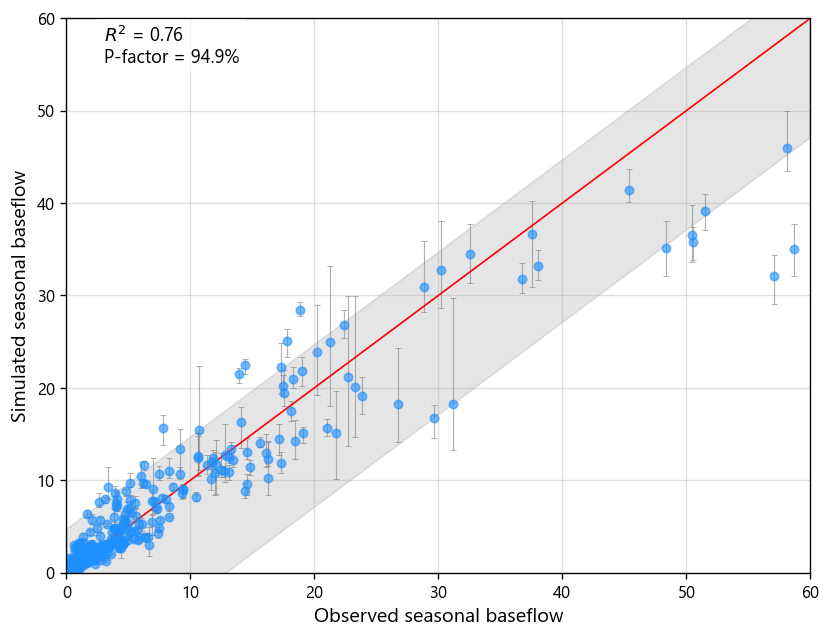

In [18]:
plot_multimodel_spread(seasonal_bf, seasons,
                       'obs_Qb', 'sim_Qb',
                       xlabel="Observed seasonal baseflow",
                       ylabel="Simulated seasonal baseflow")

In [263]:
#Calculate multimodel ensemble BFI mean
ensemble_bfi=[]
for model in models:
    df_bfi = all_models_BFI[model]
    ensemble_bfi.append(df_bfi)

#concatenate ensemble
ensemble_bfi=pd.concat(ensemble_bfi, axis=1).mean(numeric_only=True, axis=1)
ensemble_bfi_df=pd.DataFrame({'ens_bfi': ensemble_bfi})

In [240]:
from scipy import stats
model = 'MRI-ESM2-0'
# obs_bfi and sim_bfi are 1D arrays aligned by station
obs_bfi = all_models_BFI[model]['obs_bfi']
sim_bfi = all_models_BFI[model]['sim_bfi']

assert len(obs_bfi) == len(sim_bfi)
n = len(obs_bfi)
diff = sim_bfi - obs_bfi
diff=diff[diff<0.3]

# common bins
bins = np.linspace(min(obs_bfi.min(), sim_bfi.min()),
                   max(obs_bfi.max(), sim_bfi.max()), 25)

# bootstrap CI helper
def mean_ci(a, nboot=10000, alpha=0.05, rng=None):
    rng = np.random.default_rng(rng)
    boot = rng.choice(a, (nboot, a.size), replace=True).mean(axis=1)
    return a.mean(), np.quantile(boot, [alpha/2, 1-alpha/2])

m_obs, (lo_obs, hi_obs) = mean_ci(obs_bfi)
m_sim, (lo_sim, hi_sim) = mean_ci(sim_bfi)
m_diff, (lo_diff, hi_diff) = mean_ci(diff)

# paired test (choose one)
tstat, p_t = stats.ttest_rel(sim_bfi, obs_bfi)      # parametric
wstat, p_w = stats.wilcoxon(sim_bfi, obs_bfi)       # nonparametric

In [166]:
#change station_locations to upper
station_locations['name'] = station_locations['name'].str.upper()

#only unique station names
station_locations_df = station_locations.drop_duplicates(subset='name').set_index('name')
obs_bfi_df = all_models_BFI[model][['name','obs_bfi']].set_index('name')

#merge station_locations with obs_bfi on 'name'
bfi_obs_df = pd.concat([station_locations_df, obs_bfi_df], axis=1).dropna()
#bfi_obs_gdf = gpd.GeoDataFrame(bfi_obs_df, geometry=gpd.points_from_xy(bfi_obs_df['lon'], bfi_obs_df['lat']))

for model in models:
    bfi_diff_df = all_models_BFI[model]['sim_bfi'] - all_models_BFI[model]['obs_bfi']
    bfi_diff_df = pd.DataFrame(bfi_diff_df, columns=[f'bfi_diff'])
    bfi_diff_df.index = all_models_BFI[model]['name']

    bfi_diff_df = pd.concat([station_locations_df, bfi_diff_df], axis=1).dropna()

    #to geodataframe
    bfi_diff_gdf = gpd.GeoDataFrame(bfi_diff_df, geometry=gpd.points_from_xy(bfi_diff_df['lon'], bfi_diff_df['lat']))
    bfi_diff_gdf.crs = "EPSG:4326"

In [234]:
bfi_diff_gdf=bfi_diff_gdf[bfi_diff_gdf['bfi_diff']<0.3]

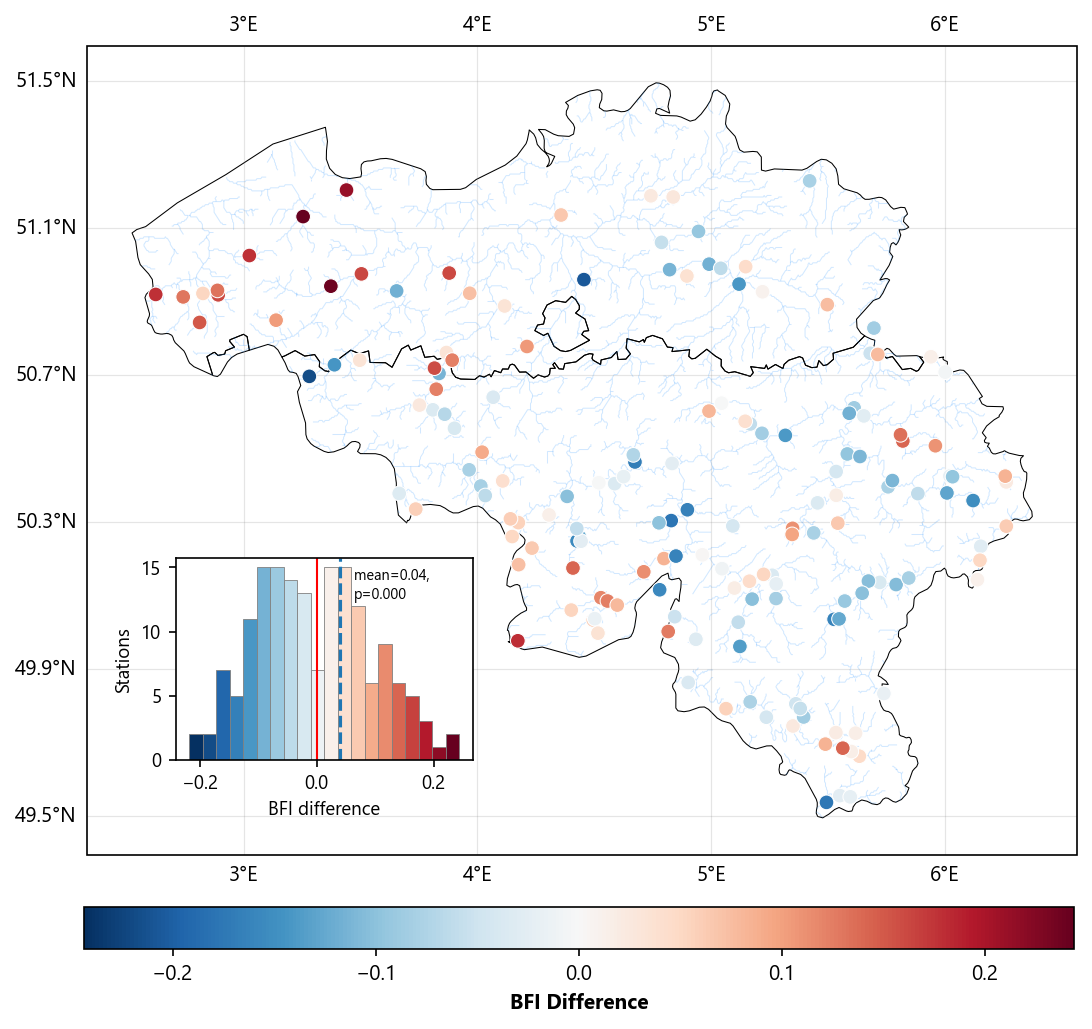

In [253]:
#### Map the BFI and KGE values
import matplotlib
from matplotlib.colors import TwoSlopeNorm
fig, ax = plt.subplots(figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)

be_shp.plot(ax=ax, linewidth=0.5,
              edgecolor='black', facecolor='none', zorder=1, transform=ccrs.PlateCarree())

rivers_shp.plot(ax=ax, linewidth=0.5, alpha=0.2,
                edgecolor='dodgerblue', facecolor='none', zorder=2, transform=ccrs.PlateCarree())


diff = bfi_diff_gdf['bfi_diff'].to_numpy()

# color: diverging, centered at 0
vmax = np.nanpercentile(np.abs(diff), 100)  # robust limits
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
cmap = 'RdBu_r'  # blue = negative, red = positive (reverse if you prefer)

# size: scale |diff| to [smin, smax]
mag = np.abs(diff)
smin, smax = 30, 300
sizes = np.interp(mag, [mag.min(), mag.max()], [smin, smax])

sc = ax.scatter(
    bfi_diff_gdf.geometry.x, bfi_diff_gdf.geometry.y,
    c=diff,
    s=50,
    cmap=cmap,
    norm=norm,
    edgecolor='white',
    linewidth=0.5,
    transform=ccrs.PlateCarree(),
    zorder=3
)

gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
gl.xlocator = plt.FixedLocator(np.arange(0, 10, 1))
gl.ylocator = plt.FixedLocator(np.arange(49.5, 51.9, 0.4))
gl.top_labels = True
gl.right_labels = False

#Insert inset histogram of BFI values
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax_in = inset_axes(ax, width="30%", height="25%", bbox_to_anchor=(-.60, -.62, 1.0, 1.0), bbox_transform=ax.transAxes)
ax_in.axvline(0, linewidth=1, color='red')
ax_in.axvline(m_diff, linestyle='--')
#ax_in.axvspan(lo_diff, hi_diff, alpha=0.2)
ax_in.text(0.6, 0.95, f'mean={m_diff:.02f},  \np={p_w:.3f}',
           transform=ax_in.transAxes, va='top', fontsize=7)
cm = matplotlib.colormaps[cmap]
_, bins, patches = ax_in.hist(diff, bins=20, color="r")  # Corrected axis
bin_centers = 0.5*(bins[:-1]+bins[1:])
col = bin_centers - min(bin_centers)
if np.max(col) > 0:
    col /= np.max(col)

for c, p in zip(col, patches):
    plt.setp(p, "facecolor", cm(c))
    edgecolor = 'gray'
    lwidth = 0.4
    plt.setp(p, "edgecolor", edgecolor, "linewidth", lwidth)
ax_in.set_xlabel('BFI difference', fontsize=9)
ax_in.set_ylabel('Stations', fontsize=9)
ax_in.tick_params(labelsize=9)

cax = fig.add_axes([0.291, 0.02, 0.44, 0.04]) #left, bottom, width, height
cmap = plt.get_cmap(cmap)

cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('BFI Difference', fontsize=10, weight='bold')

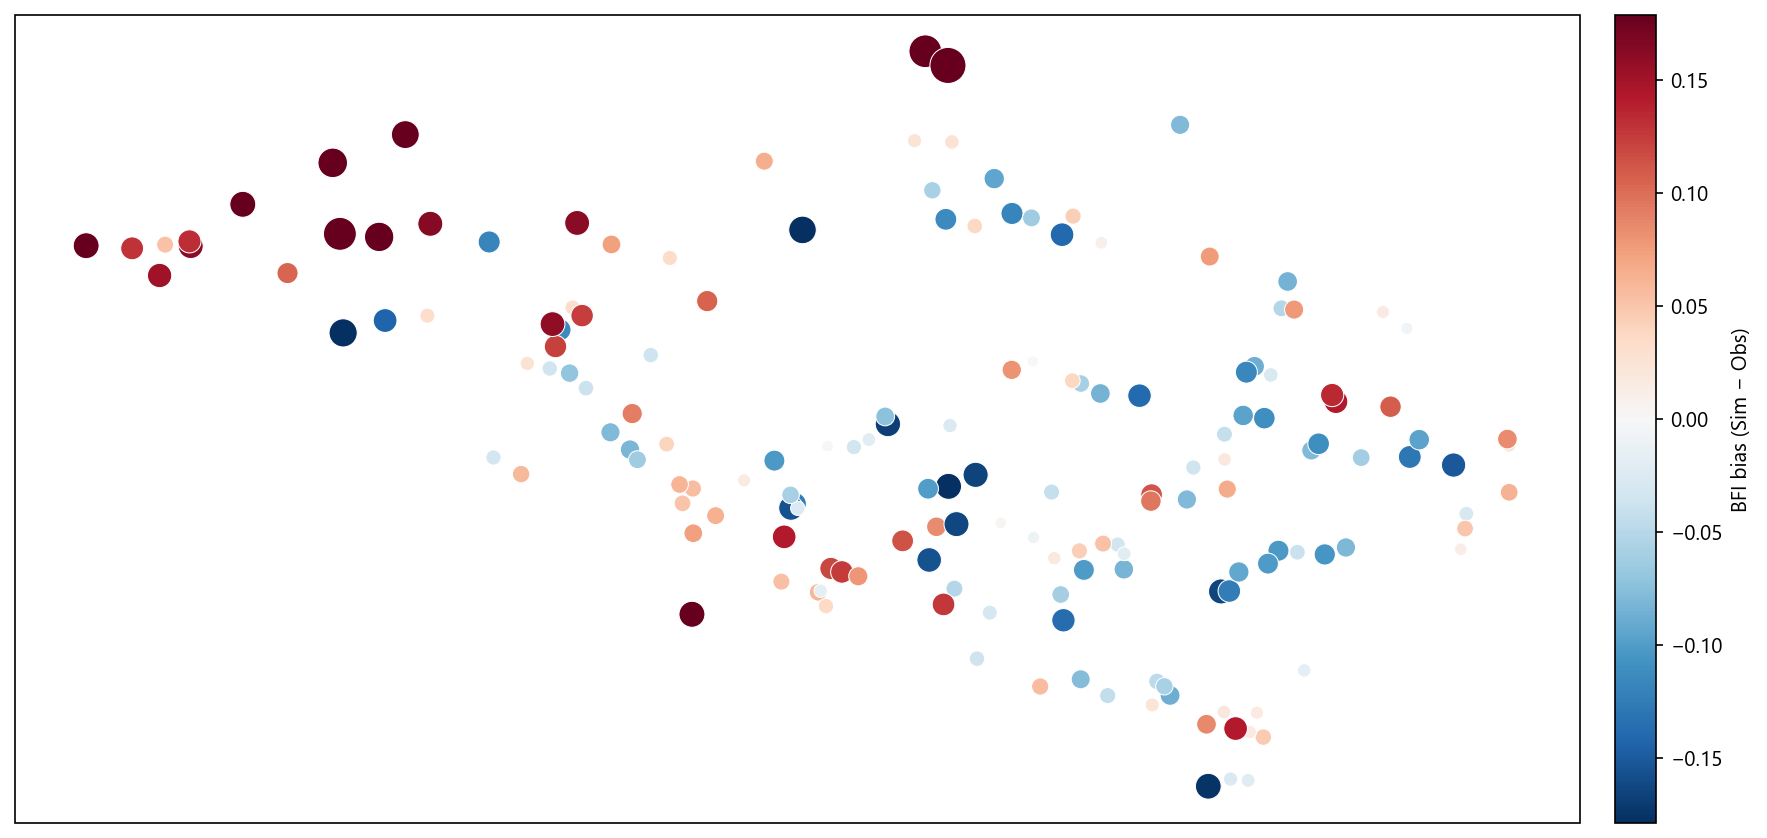

In [205]:
import numpy as np
from matplotlib.colors import TwoSlopeNorm
#### Map the BFI and KGE values
fig, ax = plt.subplots(figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)

diff = bfi_diff_gdf['bfi_diff'].to_numpy()

# color: diverging, centered at 0
vmax = np.nanpercentile(np.abs(diff), 95)  # robust limits
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
cmap = 'RdBu_r'  # blue = negative, red = positive (reverse if you prefer)

# size: scale |diff| to [smin, smax]
mag = np.abs(diff)
smin, smax = 30, 300
sizes = np.interp(mag, [mag.min(), mag.max()], [smin, smax])

sc = ax.scatter(
    bfi_diff_gdf.geometry.x, bfi_diff_gdf.geometry.y,
    c=diff,
    s=sizes,
    cmap=cmap,
    norm=norm,
    edgecolor='white',
    linewidth=0.5,
    transform=ccrs.PlateCarree(),
    zorder=3
)

# colorbar
cb = plt.colorbar(sc, ax=ax, fraction=0.036, pad=0.02)
cb.set_label('BFI bias (Sim − Obs)')
